In [1]:
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [24,16] # bigger figures
from matplotlib import style
style.use('fivethirtyeight')

In [2]:
# import package
# installed via pip
from emtracks.particle import trajectory_solver # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function
from emtracks.Bdist import get_B_df_distorted
import matplotlib.animation as animation

ERROR! Please set $EMTRACKS_DDIR and $EMTRACKS_PDIR. Setting defaults (current directory)


In [3]:
testdir = "/home/darren/Desktop/plots/"
datadir = "/home/shared_data/"
plotdir = datadir+"plots/randomphi/"
mapdir = datadir+"Bmaps/"
date = "/6-20/"

In [4]:
def readpickle():
    N = int(np.load(testdir+'lineargraded/nval.npy'))
    phis = np.load(testdir+'lineargraded/phis.npy')
    nomdata = {}
    disdata = {}
    for phi in phis:
        dataframenom = pd.read_pickle(testdir+'lineargraded/50gaussnom/'+str(phi))
        dataframedis = pd.read_pickle(testdir+'lineargraded/50gaussdis/'+str(phi))
        nomdata.update({str(phi): dataframenom})
        disdata.update({str(phi): dataframedis})
    return nomdata, disdata, phis, N

In [5]:
nomdata, disdata, phis, N = readpickle()

In [6]:
def find_track_at_z(df, z): 
    delta = (df.z.max() - df.z.min()) / len(df.z)
    #delta = 10/4001   #approximate z range divided by number of points
    mask = (df['z'] < z + delta) & (df['z'] > z - delta)
    
    while (len(df.z[mask]) > 2):
        delta = delta / 2
        mask = (df.z < z + delta) & (df.z > z - delta)
    while (len(df.z[mask]) == 0):
        delta = delta*2
        mask = (df.z < z + delta) & (df.z > z - delta)
    df2 = df.loc[mask]
    df2 = df2.apply(pd.to_numeric)
    return ([df2.iloc[0]['x'], df2.iloc[0]['y'], df2.iloc[0]['z'], df2.iloc[0]['t'], df2.iloc[0]['r']])

In [7]:
find_track_at_z(nomdata[str(phis[1])], 10)

[0.14478681281168432,
 0.4412354805924895,
 9.999839425827847,
 2.107e-08,
 0.4643834304729777]

In [8]:
def hi(zstart, zend, numpoints):   #rmax, rmin, xmax, xmin, ymax, ymin
    q = np.linspace(zstart, zend, numpoints)
    nomdata, disdata, phis, N = readpickle()    
    e = np.tile(q, len(phis))
    f = np.repeat(phis, numpoints)
    
    nomfinaldata = []
    disfinaldata = []
    
    for phi in phis:
        for i in q:
            nomfinaldata.append(find_track_at_z(nomdata[str(phi)], i))
            disfinaldata.append(find_track_at_z(disdata[str(phi)], i))
    
    nomfinaldatares = []
    disfinaldatares = []
     
    for i in q:
        transitionlistnom = []
        transitionlistdis = []
        
        for phi in phis:
            transitionlistnom.append(find_track_at_z(nomdata[str(phi)], i))
            transitionlistdis.append(find_track_at_z(disdata[str(phi)], i))
        
        nomfinaldatares.append(transitionlistnom)
        disfinaldatares.append(transitionlistdis)
       
    
    return nomfinaldata, disfinaldata, nomfinaldatares, disfinaldatares, e, f, q, numpoints

In [51]:
x = hi(6, 13, 30)

nominaldata = x[0]
gradeddata = x[1]
nomfinaldatares = np.array(x[2])
disfinaldatares = np.array(x[3])
indices = x[4]
phi_index = x[5]
q = (x[6])
numpoints = x[7]

In [57]:
arrays = (phi_index, indices)
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names = ['phi', 'z_val'])
df = pd.DataFrame(nominaldata, columns = ["X", "Y", "Z", "T", "R"], index = index)
df

X         Y          Z             T         R
phi      z_val                                                           
0.000000 6.000000   0.073281  0.039613   5.999990  7.400000e-11  0.083302
         6.241379   0.246511  0.345808   6.241378  1.666000e-09  0.424678
         6.482759  -0.065154  0.437053   6.482722  3.134000e-09  0.441882
         6.724138  -0.129428  0.145562   6.724101  4.500000e-09  0.194782
         6.965517   0.155473  0.062473   6.965214  5.848000e-09  0.167555
...                      ...       ...        ...           ...       ...
6.283185 12.034483 -0.141629  0.446938  12.034495  3.097800e-08  0.468841
         12.275862 -0.173519  0.207025  12.275711  3.214200e-08  0.270127
         12.517241  0.008505  0.048711  12.516972  3.330400e-08  0.049448
         12.758621  0.241123  0.112578  12.758332  3.446600e-08  0.266109
         13.000000  0.317843  0.341321  12.999740  3.562800e-08  0.466394

[450 rows x 5 columns]

In [56]:
dfone = df.stack().unstack(0)
dfone

phi          0.000000      0.448799      0.897598      1.346397      1.795196  \
z_val                                                                           
6.0   X  7.328123e-02  7.099740e-02  6.536608e-02  5.750261e-02  4.896447e-02   
      Y  3.961260e-02  4.784905e-02  5.427891e-02  5.762869e-02  5.723490e-02   
      Z  5.999990e+00  5.999993e+00  5.999995e+00  5.999997e+00  5.999998e+00   
      T  7.400000e-11  7.400000e-11  7.400000e-11  7.400000e-11  7.400000e-11   
      R  8.330244e-02  8.561637e-02  8.496426e-02  8.141017e-02  7.532166e-02   
...               ...           ...           ...           ...           ...   
13.0  X  3.178425e-01  1.690349e-01  7.845352e-03 -1.384209e-01 -2.449520e-01   
      Y  3.413205e-01  4.135997e-01  4.170038e-01  3.548731e-01  2.393429e-01   
      Z  1.299974e+01  1.300007e+01  1.299991e+01  1.299996e+01  1.300008e+01   
      T  3.562800e-08  3.558600e-08  3.553800e-08  3.549400e-08  3.545400e-08   
      R  4.663942e-01  4.468081e-01  4.170776e-01  3.809137e-01  3.424712e-01   

phi          2.243995      2.692794      3.141593      3.590392      4.039191  \
z_val                                                                           
6.0   X  4.144272e-02  3.642715e-02  3.491115e-02  3.719498e-02  4.282631e-02   
      Y  5.317554e-02  4.625462e-02  3.784292e-02  2.960647e-02  2.317661e-02   
      Z  5.999998e+00  5.999998e+00  5.999996e+00  5.999993e+00  5.999991e+00   
      T  7.400000e-11  7.400000e-11  7.400000e-11  7.400000e-11  7.400000e-11   
      R  6.741763e-02  5.887637e-02  5.148665e-02  4.753956e-02  4.869546e-02   
...               ...           ...           ...           ...           ...   
13.0  X -2.932705e-01 -2.762558e-01 -1.965290e-01 -6.446474e-02  1.022730e-01   
      Y  9.168264e-02 -6.234946e-02 -1.972826e-01 -2.901501e-01 -3.201781e-01   
      Z  1.299989e+01  1.299979e+01  1.299983e+01  1.299987e+01  1.299998e+01   
      T  3.541600e-08  3.538600e-08  3.537200e-08  3.538400e-08  3.543000e-08   
      R  3.072675e-01  2.832044e-01  2.784674e-01  2.972251e-01  3.361157e-01   

phi          4.487990      4.936788      5.385587      5.834386      6.283185  
z_val                                                                          
6.0   X  5.068977e-02  5.922792e-02  6.674966e-02  7.176523e-02  7.328123e-02  
      Y  1.982684e-02  2.022063e-02  2.427999e-02  3.120090e-02  3.961260e-02  
      Z  5.999989e+00  5.999988e+00  5.999988e+00  5.999989e+00  5.999990e+00  
      T  7.400000e-11  7.400000e-11  7.400000e-11  7.400000e-11  7.400000e-11  
      R  5.442937e-02  6.258451e-02  7.102841e-02  7.825436e-02  8.330244e-02  
...               ...           ...           ...           ...           ...  
13.0  X  2.735920e-01  4.055312e-01  4.596332e-01  4.244440e-01  3.178425e-01  
      Y -2.705618e-01 -1.424819e-01  3.315835e-02  2.077340e-01  3.413205e-01  
      Z  1.300008e+01  1.299978e+01  1.299982e+01  1.299982e+01  1.299974e+01  
      T  3.550400e-08  3.558200e-08  3.563800e-08  3.565200e-08  3.562800e-08  
      R  3.847809e-01  4.298333e-01  4.608277e-01  4.725528e-01  4.663942e-01  

[150 rows x 15 columns]

In [54]:
title = phis.tolist()
title.insert(0, 'z')
xdif = [title]
ydif = [title]
rdif = [title]

for i in range(0, len(nomfinaldatares), 1): #specific z value
    xtransitionlist = [q[i]]
    ytransitionlist = [q[i]]
    rtransitionlist = [q[i]]
    
    for j in range(0, len(nomfinaldatares[0])): #specific phi value
        xtransitionlist.append(nomfinaldatares[i][j][0] - disfinaldatares[i][j][0])
        ytransitionlist.append(nomfinaldatares[i][j][1] - disfinaldatares[i][j][1])
        rtransitionlist.append(nomfinaldatares[i][j][4] - disfinaldatares[i][j][4])
    
    xdif.append(xtransitionlist)
    ydif.append(ytransitionlist)
    rdif.append(rtransitionlist)  #rdif[0] - has same z values, rdif[0][1] has same phi value, 
                                  #rdif[i][0] when i > 0 is the z value for that block
                                  #phi values top row

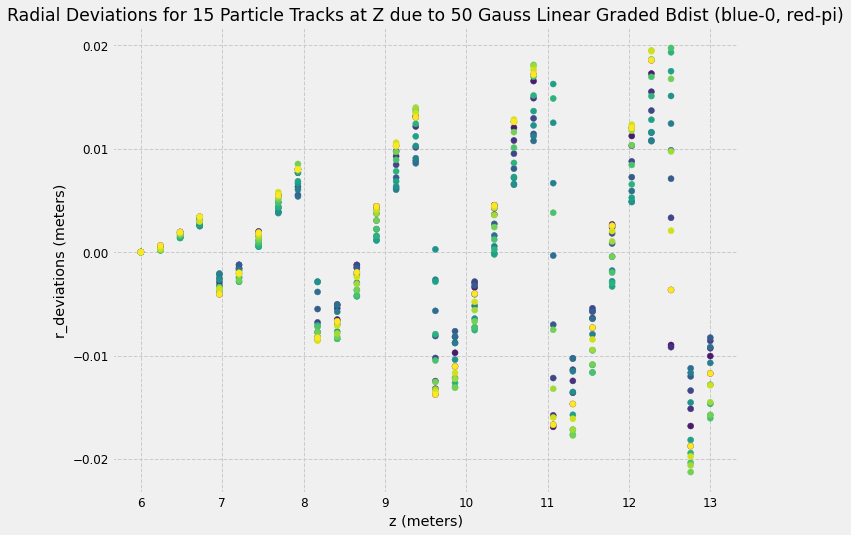

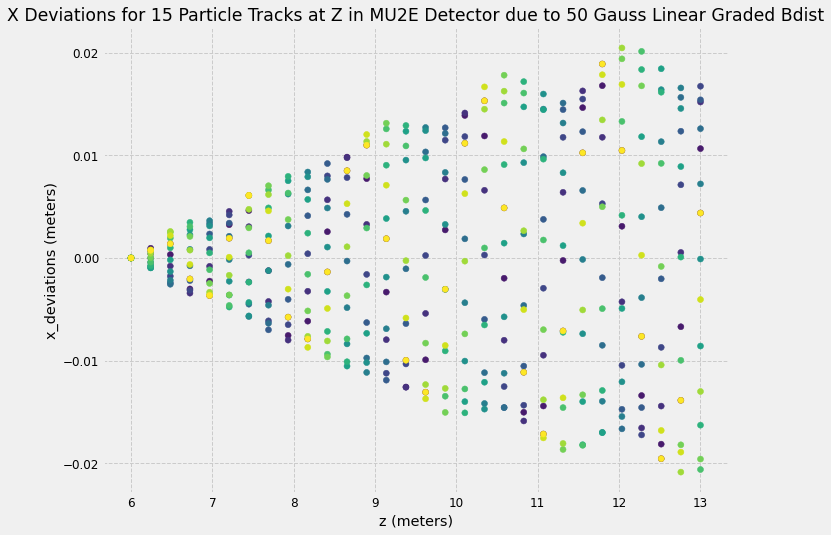

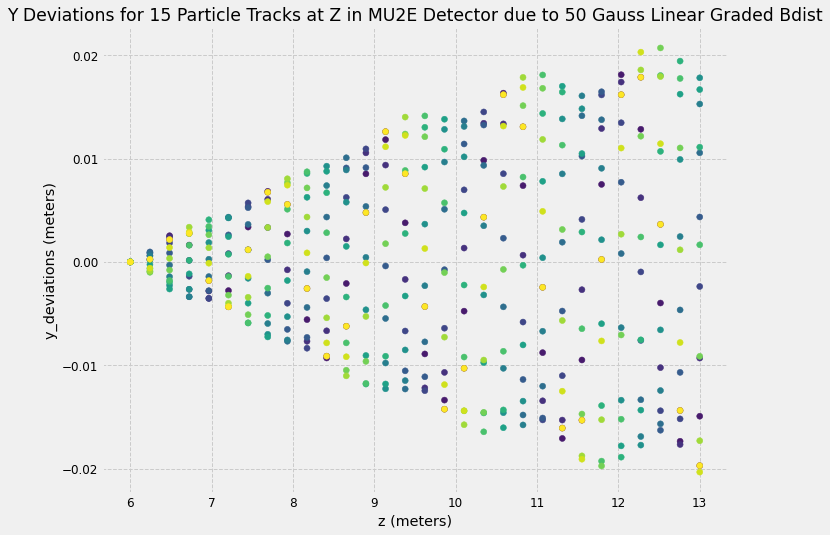

In [55]:
fig = plt.figure()
for i in range(1, len(rdif), 1):
    a = np.full((len(rdif[1])-1), rdif[i][0])
    plt.scatter(a, rdif[i][1:], c = rdif[0][1:])
     
plt.xlabel("z (meters)")
plt.ylabel("r_deviations (meters)")
plt.title("Radial Deviations for 15 Particle Tracks at Z due to 50 Gauss Linear Graded Bdist (blue-0, red-pi)")
fig.savefig(testdir+'6-22-7')

fig1 = plt.figure()
for i in range(1, len(xdif), 1):
    a = np.full((len(xdif[1])-1), xdif[i][0])
    plt.scatter(a, xdif[i][1:], c = xdif[0][1:])
    
plt.xlabel("z (meters)")
plt.ylabel("x_deviations (meters)")
plt.title("X Deviations for 15 Particle Tracks at Z in MU2E Detector due to 50 Gauss Linear Graded Bdist")
fig1.savefig(testdir+'6-22-8')

fig2 = plt.figure()
for i in range(1, len(ydif), 1):
    a = np.full((len(ydif[1])-1), ydif[i][0])
    plt.scatter(a, ydif[i][1:], c = ydif[0][1:])
    
plt.xlabel("z (meters)")
plt.ylabel("y_deviations (meters)")
plt.title("Y Deviations for 15 Particle Tracks at Z in MU2E Detector due to 50 Gauss Linear Graded Bdist")
plt.show()
fig2.savefig(testdir+'6-22-9')